# CTD/het.io Overlap

In [22]:
%reload_ext autoreload
%autoreload 2

import os
import math
import pandas as pd
import numpy as np
from utils import log
from tqdm import tqdm
from itertools import chain

from utils.sources import load_umls, load_repodb
from utils import Node, Edge
from utils.repodb import build_nodes as build_repodb_nodes, build_edges as build_repodb_edges
from typing import List
from utils.ctd import build_nodes as build_ctd_nodes, build_edges as build_ctd_edges
from pdb import set_trace

In [7]:
UMLS_FILE_PATH = "MRCONSO.RRF"
REPODB_FILE_PATH = "data/repodb.csv"
CHEMICALS_PATH = "data/CTD_chemicals.csv"
DISEASES_PATH = "data/CTD_diseases.csv"

CHEMICAL_NODES_CHECKPOINT = "outputs/ctd_chemical_nodes.checkpoint.json"
DISEASE_NODES_CHECKPOINT = "outputs/ctd_disease_nodes.checkpoint.json"

REPODB_EDGES_CHECKPOINT = "outputs/repodb_edges.checkpoint.json"

CHEMICAL_COLUMNS = [
    "ChemicalName", "ChemicalID", "CasRN", "Definition", "ParentIDs", "TreeNumbers", "ParentTreeNumbers", "Synonyms",
    "DrugBankIDs"
]

DISEASE_COLUMNS = [
    "DiseaseName", "DiseaseID", "AltDiseaseIDs", "Definition", "ParentIDs", "TreeNumbers", "ParentTreeNumbers",
    "Synonyms", "SlimMappings"
]

def overlap(first: List[Node], second: List[Node]) -> int:
    num_overlap = 0
    
    for fir in tqdm(first):
        for sec in second:
            if fir == sec:
                num_overlap += 1
                
    return num_overlap

In [3]:
hetio_nodes = Node.deserialize_bunch("outputs/hetio_nodes.checkpoint.json")

hetio_disease_nodes = list(filter(lambda x: x.kind == "Disease", hetio_nodes))
hetio_drug_nodes = list(filter(lambda x: x.kind == "Compound", hetio_nodes))

100%|██████████| 47031/47031 [00:00<00:00, 226445.21it/s]


In [8]:
repodb = load_repodb(REPODB_FILE_PATH)
repodb_nodes = build_repodb_nodes(repodb, force_rebuild=False)

repodb_chemical_nodes = list(filter(lambda x: x.kind == "Compound", repodb_nodes))
repodb_disease_nodes = list(filter(lambda x: x.kind == "Disease", repodb_nodes))

100%|██████████| 3646/3646 [00:00<00:00, 52360.41it/s]


In [16]:
def build_chemical_nodes(**kwargs) -> List[Node]:
    chemicals = pd.read_csv(CHEMICALS_PATH, names=CHEMICAL_COLUMNS)
    nodes = []

    if not kwargs.get("force_rebuild", False):
        if os.path.exists(CHEMICAL_NODES_CHECKPOINT):
            return Node.deserialize_bunch(CHEMICAL_NODES_CHECKPOINT)
        else:
            log.info("Node checkpoint does not exist, building nodes.")

    for idx, row in tqdm(chemicals.iterrows()):
        # All of the chemicals start with "MESH:"
        chemical_id = row["ChemicalID"][5:]
        chemical_name = row["ChemicalName"]

        # drug bank ids are delimited by "|"
        drug_bank_ids = row["DrugBankIDs"]
        
        node = Node(identifier=chemical_id, name=chemical_name, kind="Compound",
                    sources=["Comparative Toxicgenomic Dataset"], license="?")

        if type(drug_bank_ids) == float and math.isnan(drug_bank_ids):
            drug_bank_ids = ""

        if "|" in drug_bank_ids:
            drug_bank_ids = drug_bank_ids.split("|")
        
        node.add_mesh_id(chemical_id)
        
        if not (drug_bank_ids == ""):
            node.add_drug_bank_id(drug_bank_ids)
#         node.add_alt_id(drug_bank_ids, id_type="DRUGBANK")
        nodes.append(node)

    if kwargs.get("save_checkpoint", True):
        log.info("Check-pointing nodes...")
        Node.serialize_bunch(nodes, CHEMICAL_NODES_CHECKPOINT)

    return nodes


def build_disease_nodes(**kwargs) -> List[Node]:
    diseases = pd.read_csv(DISEASES_PATH, names=DISEASE_COLUMNS)
    nodes = []

    if not kwargs.get("force_rebuild", False):
        if os.path.exists(DISEASE_NODES_CHECKPOINT):
            return Node.deserialize_bunch(DISEASE_NODES_CHECKPOINT)
        else:
            log.info("Node checkpoint does not exist, building nodes.")

    for idx, row in tqdm(diseases.iterrows()):
        # All of the diseases start with "MESH:" or "OMIM:"
        disease_prefix, disease_id = row["DiseaseID"][:4], row["DiseaseID"][5:]
        disease_name = row["DiseaseName"]

        node = Node(identifier=disease_id, name=disease_name, kind="Disease",
                    sources=["Comparative Toxicgenomic Dataset"], license="?")

        if disease_prefix == "MESH":
            node.add_mesh_id(disease_id)
#             node.add_alt_id(disease_id, id_type="MESH")
        elif disease_prefix == "OMIM":
#             node.add_alt_id(disease_id, id_type="OMIM")
            pass
        else:
            raise ValueError(f"Unrecognized disease prefix: {disease_prefix}, expecting \"MESH\" or \"OMIM\".")

        nodes.append(node)

    if kwargs.get("save_checkpoint", True):
        log.info("Check-pointing nodes...")
        Node.serialize_bunch(nodes, DISEASE_NODES_CHECKPOINT)

    return nodes

# ctd_chemical_nodes = build_chemical_nodes(force_rebuild=False)
# ctd_disease_nodes = build_disease_nodes(force_rebuild=False)
ctd_chemical_nodes, ctd_disease_nodes, _, _ = build_ctd_nodes()

2019-12-02 22:48:59,345 [INFO] Building chemical nodes...


100%|██████████| 171203/171203 [00:00<00:00, 202116.71it/s]


2019-12-02 22:49:02,943 [INFO] Building disease nodes...


100%|██████████| 12985/12985 [00:00<00:00, 606013.48it/s]

2019-12-02 22:49:03,133 [INFO] Building gene nodes...



100%|██████████| 502066/502066 [00:01<00:00, 280923.87it/s]


2019-12-02 22:49:10,048 [INFO] Building pathway nodes...


100%|██████████| 2363/2363 [00:00<00:00, 481848.43it/s]


In [10]:
# Add UMLS metadata to the nodes
umls = load_umls()
umls.head(5)

2019-12-02 22:36:36,317 [INFO] Loading UMLS file.
2019-12-02 22:37:40,911 [INFO] Finished loading UMLS file.


,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,MISC
0,C0000005,ENG,P,L0000005,PF,S0007492,Y,A26634265,NaN,M0019694,D012711,MSH,PEP,D012711,(131)I-Macroaggregated Albumin,0,N,256.0,NaN
1,C0000005,ENG,S,L0270109,PF,S0007491,Y,A26634266,NaN,M0019694,D012711,MSH,ET,D012711,(131)I-MAA,0,N,256.0,NaN
6,C0000039,ENG,P,L0000039,PF,S17175117,N,A28315139,9194921.0,1926948,NaN,RXNORM,IN,1926948,"1,2-dipalmitoylphosphatidylcholine",0,N,256.0,NaN
7,C0000039,ENG,P,L0000039,PF,S17175117,Y,A28572604,NaN,NaN,NaN,MTH,PN,NOCODE,"1,2-dipalmitoylphosphatidylcholine",0,N,256.0,NaN
8,C0000039,ENG,P,L0000039,VC,S0007564,N,A17972823,NaN,N0000007747,NaN,NDFRT,PT,N0000007747,"1,2-Dipalmitoylphosphatidylcholine",0,N,NaN,NaN


In [5]:
umls["SAB"].unique()

array(['MSH', 'RXNORM', 'MTH', 'NDFRT', 'SNMI', 'LNC', 'SNOMEDCT_US',
       'SNM', 'CSP', 'PSY', 'CHV', 'RCD', 'LCH_NW', 'AOD', 'CPM', 'GO',
       'LCH', 'NCI', 'NCI_FDA', 'NCI_CTRP', 'MMSL', 'PDQ', 'NCI_DTP',
       'USPMG', 'USP', 'GS', 'MEDCIN', 'NDDF', 'ATC', 'NCI_NCI-GLOSS',
       'MTHSPL', 'VANDF', 'NCI_DCP', 'NCI_CPTAC', 'DRUGBANK',
       'MEDLINEPLUS', 'NCI_CRCH', 'NCI_CDISC-GLOSS', 'NCI_CareLex', 'CST',
       'UWDA', 'FMA', 'HL7V2.5', 'OMIM', 'ICPC2ICD10ENG', 'ICD10',
       'ICD10AM', 'MDR', 'RCDSY', 'ICD10CM', 'WHO', 'CCPSS', 'COSTAR',
       'NOC', 'MTHICD9', 'ICPC2P', 'NANDA-I', 'DXP', 'HPO',
       'SNOMEDCT_VET', 'NCI_NICHD', 'NCI_CTCAE', 'ICPC2EENG', 'ICPC',
       'QMR', 'RCDAE', 'ICNP', 'CCS', 'CCS_10', 'ICD9CM', 'BI',
       'NCI_CDISC', 'NEU', 'NCBI', 'NCI_GAIA', 'PCDS', 'MED-RT',
       'HL7V3.0', 'UMD', 'RAM', 'SPN', 'AIR', 'CCC', 'ICD10AMAE',
       'ICD10AE', 'MTHMST', 'NCI_CTEP-SDC', 'DSM-5', 'NIC', 'ALT',
       'NCI_EDQM-HC', 'RCDSA', 'ICF', 'ICF-CY', 'N

In [11]:
list(filter(lambda x: x[:2] == "NC", umls["SAB"].unique()))

['NCI',
 'NCI_FDA',
 'NCI_CTRP',
 'NCI_DTP',
 'NCI_NCI-GLOSS',
 'NCI_DCP',
 'NCI_CPTAC',
 'NCI_CRCH',
 'NCI_CDISC-GLOSS',
 'NCI_CareLex',
 'NCI_NICHD',
 'NCI_CTCAE',
 'NCI_CDISC',
 'NCBI',
 'NCI_GAIA',
 'NCI_CTEP-SDC',
 'NCI_EDQM-HC',
 'NCI_GENC',
 'NCI_BRIDG',
 'NCI_CDC',
 'NCI_NCPDP',
 'NCI_DICOM',
 'NCI_KEGG',
 'NCI_UCUM',
 'NCI_BioC',
 'NCI_NCI-HGNC',
 'NCI_NCI-HL7',
 'NCI_JAX',
 'NCI_PI-RADS',
 'NCI_ICH',
 'NCI_CTCAE_3',
 'NCI_PID',
 'NCI_CTCAE_5',
 'NCI_RENI',
 'NCI_ZFin',
 'NCI_INC']

In [24]:
umls[(umls["CODE"] == "407394")] # & (umls["SAB"] == "NCBI")]

,CUI,LAT,TS,LUI,STT,SUI,ISPREF,AUI,SAUI,SCUI,SDUI,SAB,TTY,CODE,STR,SRL,SUPPRESS,CVF,MISC


In [25]:
len(ctd_disease_nodes)

12985

In [26]:
len(repodb_disease_nodes)

2074

In [17]:
# Add the UMLS CUIs and other MESH codes to CTD

ctd_mesh_ids = list(map(lambda x: x.identifier, ctd_disease_nodes))
umls_ctd_subset = umls[(umls["SAB"] == "MSH") & (umls["CODE"].isin(ctd_mesh_ids) )]

for node in tqdm(ctd_disease_nodes):
    matching_records = umls_ctd_subset[umls_ctd_subset["CODE"] == node.identifier]
    umls_ids = list(set(matching_records["CUI"]))
    mesh_ids = list(set(matching_records["CODE"]))
    node.add_cui(umls_ids)
    node.add_mesh_id(mesh_ids)

100%|██████████| 12985/12985 [01:00<00:00, 214.34it/s]


In [30]:
umls_ids = list(map(lambda x: x.umls_cuis, ctd_disease_nodes))
len(list(chain(*umls_ids)))

16005

In [13]:
# Add the UMLS CUIs and other MESH codes to RepoDB

repodb_mesh_ids = list(map(lambda x: x.identifier, repodb_disease_nodes))
umls_repodb_subset = umls[(umls["SAB"] == "MSH") & (umls["CODE"].isin(repodb_mesh_ids) )]

for node in tqdm(repodb_disease_nodes):
    matching_records = umls_repodb_subset[umls_repodb_subset["CODE"] == node.identifier]
    umls_ids = list(set(matching_records["CUI"]))
    mesh_ids = list(set(matching_records["CODE"]))
    node.add_cui(umls_ids)
    node.add_mesh_id(mesh_ids)

100%|██████████| 2074/2074 [00:01<00:00, 1313.95it/s]


In [28]:
umls_ids = list(map(lambda x: x.umls_cuis, repodb_disease_nodes))
list(chain(*umls_ids))

[]

In [9]:
# het.io Drug overlap

# print(f"There are {len(hetio_drug_nodes)} drug nodes in het.io, {len(ctd_chemical_nodes)} drug nodes in CTD.")
# drug_overlap = overlap(hetio_drug_nodes, ctd_chemical_nodes)

# print(f"Drug overlap is {drug_overlap}")

# There are 1552 drug nodes in het.io, 171203 drug nodes in CTD.
# Drug overlap is 1485

In [10]:
# het.io Disease overlap

# print(f"There are {len(hetio_disease_nodes)} disease nodes in het.io, {len(ctd_disease_nodes)} disease nodes in CTD.")
# disease_overlap = overlap(hetio_disease_nodes, ctd_disease_nodes)
            
# print(f"Disease overlap is {disease_overlap}")

# There are 137 disease nodes in het.io, 12985 disease nodes in CTD.
# Disease overlap is 132

In [11]:
# RepoDB Drug overlap

# print(f"There are {len(repodb_chemical_nodes)} drug nodes in repodb, {len(ctd_chemical_nodes)} drug nodes in CTD.")
# drug_overlap = overlap(repodb_chemical_nodes, ctd_chemical_nodes)

# print(f"Drug overlap is {drug_overlap}") 

# There are 1572 drug nodes in repodb, 171203 drug nodes in CTD.
# Drug overlap is 1427

In [18]:
# RepoDB Disease overlap

# print(f"There are {len(repodb_disease_nodes)} disease nodes in repodb, {len(ctd_disease_nodes)} disease nodes in CTD.")
disease_overlap = overlap(repodb_disease_nodes, ctd_disease_nodes)
            
print(f"Disease overlap is {disease_overlap}")

# There are 2074 disease nodes in repodb, 12985 disease nodes in CTD.
# Disease overlap is 1076

100%|██████████| 2074/2074 [01:15<00:00, 27.54it/s]

Disease overlap is 1076


In [13]:
# RepoDB disease overlap with het.io disease

# disease_overlap = overlap(repodb_disease_nodes, hetio_disease_nodes)
# print(f"Disease overlap is {disease_overlap}.")

# Disease overlap is 85.

In [14]:
# RepoDB drugs overlap with het.io drugs

# drug_overlap = overlap(repodb_chemical_nodes, hetio_drug_nodes)
# print(f"Drug overlap is {drug_overlap}.")

# Drug overlap is 1198.

In [16]:
# How many RepoDB edges where both head and tail exist in het.io?

# ctd_chemical_nodes
# ctd_disease_nodes

from multiprocess import Pool

def isin(node: Node, nodes: List[Node]) -> bool:
    for n in nodes:
        if node == n:
            return True
        
    return False

repodb_edges = build_repodb_edges(repodb, repodb_nodes, force_rebuild=False)
print(f"There are {len(repodb_edges)} edges before filtering.")

with Pool(8) as pool:
    repodb_edges = pool.map(lambda x: x if isin(x.source, ctd_chemical_nodes) and isin(x.destination, ctd_disease_nodes) else None, repodb_edges)

# edges = list(filter(lambda x: isin(x.source, ctd_chemical_nodes) and isin(x.destination, ctd_disease_nodes), repodb_edges))

# for edge in tqdm(repodb_edges):
#     head, tail = edge.source, edge.destination
#     if isin(head, ctd_chemical_nodes) and isin(tail, ctd_disease_nodes):
#         edges.append(edge)

repodb_edges = list(filter(lambda x: x is not None, repodb_edges))
print(f"There are {len(repodb_edges)} edges after filtering.")
# There are 10562 edges.

100%|██████████| 10562/10562 [00:00<00:00, 334505.52it/s]

There are 10562 edges before filtering.


There are 5588 edges after filtering.


In [17]:
from itertools import chain
from collections import Counter

nodes = list(map(lambda x: (x.source, x.destination), repodb_edges))
nodes = list(chain(*nodes))

print(f"There are {len(nodes)} nodes")

chemical_nodes = list(filter(lambda x: x.kind == "Compound", nodes))
disease_nodes = list(filter(lambda x: x.kind == "Disease", nodes))

print(f"There are {len(set(chemical_nodes))} unique chemical nodes.")
print(f"There are {len(set(disease_nodes))} unique disease nodes.")

chemical_counter = Counter(chemical_nodes)
disease_counter = Counter(disease_nodes)

There are 11176 nodes
There are 1316 unique chemical nodes.
There are 1027 unique disease nodes.


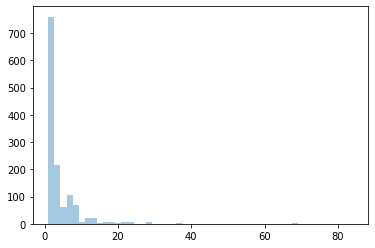

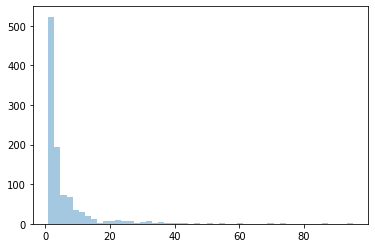

In [34]:
chemical_names, chemical_freq = list(zip(*Counter(list(map(lambda x: x.name, chemical_nodes))).items()))
disease_names, disease_freq = list(zip(*Counter(list(map(lambda x: x.name, disease_nodes))).items()))

chemical_freq = np.array(chemical_freq)
disease_freq = np.array(disease_freq)

import seaborn as sns
from matplotlib import pyplot as plt

# x-axis frequency
# y-axis how many
sns.distplot(chemical_freq, kde=False)
plt.show()

sns.distplot(disease_freq, kde=False)
plt.show()

In [18]:
treats_edges = list(filter(lambda x: x.kind == "treats", repodb_edges))
not_treats_edges = list(filter(lambda x: x.kind == "not_treats", repodb_edges))

print(f"There are {len(treats_edges)} treats edges.")
print(f"There are {len(not_treats_edges)} not treats edges.")

There are 4068 treats edges.
There are 1520 not treats edges.


In [ ]:
# most_common_chemicals = chemical_counter.most_common(10)
# most_common_diseases = disease_counter.most_common(10)

# print("")
# print(f"The most common chemicals:")

# for chem in most_common_chemicals:
#     print(f"{chem[0].name}: {chem[1]}")

# print("")
# print(f"The most common diseases:")

# for disease in most_common_diseases:
#     print(f"{disease[0].name}: {disease[1]}")